# CNNbasic Assignment#2 - Tobigs 15기 이성범

# AlexNet 구현

모델 구현 후 summary로 전체 모델 구조 출력과 주석으로 간단한 설명을 달아주시면 됩니다.

프레임워크는 자유이고, 기본 tensforflow와 pytorch tutorial 사이트를 아래에 첨부해 드립니다.

이 외 각 프레임워크 별 summary 등 추가적인 사용 방법은 구글링으로 찾아주세요!-!

- Tensorflow Tutorial: https://www.tensorflow.org/tutorials?hl=ko

- Pytorch Tutorial: https://tutorials.pytorch.kr/

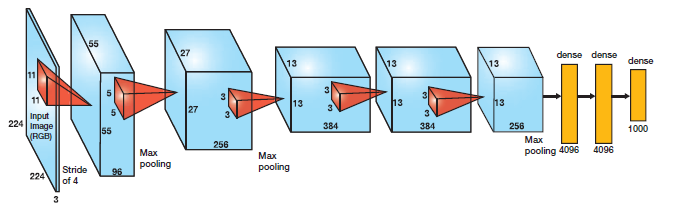

AlexNet은 5개의 convolutional layer와 3개의 fully-connected layer로 이루어졌다.

Input layer -> Conv1 -> MaxPool1 -> Norm1 -> Conv2 -> MaxPool2 -> Norm2 -> Conv3 -> Conv4 -> Conv5 -> MaxPool3 -> Dropout1 -> FC1 ->  Dropout2 -> FC2 -> Output layer

### AlexNet의 특징
- 활성화 함수로 ReLU를 활용
 - ReLU를 활성홤 함수로 사용함으로써 학습 속도를 배로 높였다.
- 훈련시에 2개의 GPU로 나누어서 학습
 - 데이터의 양이 120만개이기 때문에 하나의 GPU로 학습하기에는 시간이 오래걸리고 어렵기 때문에 2개의 GPU로 나누어 학습하여 학습속도를 높이고 모델의 성능도 향상되었다.
- Local Response Normalization을 활용
 - 학습시에 SGD 방식을 활용한다면 학습 데이터간의 분포가 달라져서(Covariate Shift) 학습이 불안정해진다. 따라서  데이터의 분포를 일정하게 만들어주기 위해서 Local Response Normalization을 활용하여 saturating을 예방하고 학습을 안정화 시켰다. 그러나 최근에는 LRN이 아닌 batch normalization 기법이 쓰이고 현재 모델에도 bn을 적용할 예정이다.
- Overlapping Pooling을 활용
 - 이미지의 크기를 줄이는 Poolng 기법을 오버랩 되게 사용함으로써 모델의 성능을 높임(좀 더 이미지의 특징을 중첩적으로 많이 찾음으로써 성능이 높아지지 않았나 추측)
- Data Augmentation을 활용
 - 과적합을 예방하고자 하나의 이미지를 가지고 여러장의 비슷한 이미지를 만들었다. 조금 더 데이터의 노이즈를 학습할 수 있음으로써 모델의 성능이 높아지지 않았나 추측됨
- Dropout을 활용
 - 과적합을 예방하고자 규제 기술의 일종인 Dropout을  적용하였다. 여기서 중요한 점은 Dropout은 훈련시에만 적용하고 테스트 시에는 모든 뉴런을 사용한다는 것이다.

## Tensorflow(keras)

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

n_classes = 1000 # class 개수
input_shape = (227, 227, 3)

model=Sequential()

############## Add Layer ##############

# Conv1
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Conv2
model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# Conv3
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')) 

# Conv4
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Conv5
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# FC1
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))

# FC2
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))

# Output_layer
model.add(Dense(n_classes, activation='softmax'))

#######################################

# keras summary
model.summary() # summary code 추가

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

## Pytorch

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class AlexNet(nn.Module):

    def __init__(self, n_classes = 1000):
        super(AlexNet, self).__init__()
        
        ############## Add Layer ##############

        # Conv1
        self.Conv_1 = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(96))
        
        # Conv2
        self.Conv_2 = nn.Sequential(
          nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(256))
        
        # Conv3
        self.Conv_3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())
        
        # Conv4
        self.Conv_4 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())
        
        # Conv5
        self.Conv_5 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # FC1
        self.FC1 = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.5),
          nn.Linear(9216, 4096),
          nn.ReLU()
        )

        # FC2
        self.FC2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU()
        )

        # Output_layer
        self.Output_layer = nn.Sequential(
          nn.Linear(4096, n_classes)
        )
    
        #######################################

    def forward(self, x):
        
        ############## Add Layer ##############
        out = self.Conv_1(x)
        out = self.Conv_2(out)
        out = self.Conv_3(out)
        out = self.Conv_4(out)
        out = self.Conv_5(out)
        out = self.FC1(out)
        out = self.FC2(out)
        out = self.Output_layer(out)
    
        #######################################
        
        # 크로스 엔트로피 계산시 log_softmax를 사용하면 두번 log_softmax를 사용해도 동일한 값을 
        # 출력하기 때문에 log_softmax를 사용해도 손실함수 계산에 영향을 안 줌
        return F.log_softmax(out)


# pytorch summary
summary(AlexNet(n_classes = 1000), (3, 227, 227)) # summary code 추가

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
       BatchNorm2d-4           [-1, 96, 27, 27]             192
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 13, 13]               0
       BatchNorm2d-8          [-1, 256, 13, 13]             512
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


참고자료
- https://bskyvision.com/421
- https://deep-learning-study.tistory.com/376